# Generalized Extreme Value Distribution



## Introduction

La distribution des valeurs extrêmes généralisée (GEV) regroupe les trois grandes familles de lois extrêmes : Weibull, Gumbel et Fréchet. Elle permet de modéliser la distribution des valeurs extrêmes (maximums ou minimums) issues de processus stationnaires — tels que les vitesses maximales du vent enregistrées annuellement, ou le poids maximal de camions franchissant un pont — sans nécessiter une hypothèse *a priori* sur le comportement des queues de distribution.

En suivant la paramétrisation présentée par {cite:t}`coles2001gev`, la forme de la distribution GEV pour les maximums est donnée par :

$$
G(x) = \exp \left\{ \left[ 1 - \xi \left( \frac{x - \mu}{\sigma} \right) \right]^{-\frac{1}{\xi}} \right\}
$$

Les cas particuliers selon la valeur du paramètre de forme $\xi$ sont :
- $\xi < 0$ : correspond à la loi de Weibull, avec une queue supérieure bornée ;
- $\xi = 0$ (dans la limite) : correspond à la loi de Gumbel, non bornée de part et d'autre ;
- $\xi > 0$ : correspond à la loi de Fréchet, bornée dans la queue inférieure.

> ⚠️ Remarque : cette convention de signe pour $\xi$ est opposée à celle adoptée dans la bibliothèque SciPy, où ce paramètre est noté `c`.

Enfin, pour étudier les minimums, il suffit d’analyser la distribution des maximums des valeurs opposées.

Dans ce notebook, nous allons illustrer l’utilisation de la loi GEV à travers l’exemple des hauteurs annuelles maximales de la mer enregistrées à Port Pirie, tel que décrit dans {cite:t}`coles2001gev`, et comparer les résultats obtenus à ceux d’une approche fréquentiste.


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd


## Données

Les données utilisées ici proviennent de l’exemple classique de Port Pirie présenté dans {cite:t}`coles2001gev`. Elles correspondent aux hauteurs maximales annuelles de la mer enregistrées dans cette région. Pour faciliter leur réutilisation, elles sont reprises ci-dessous dans le notebook.


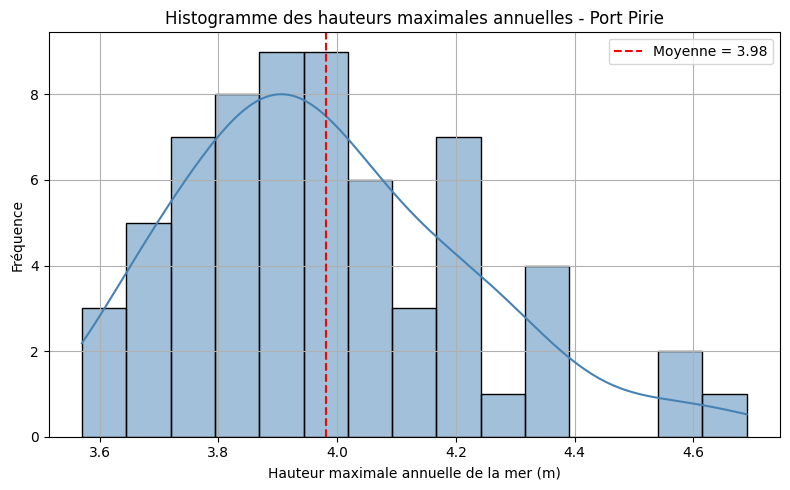

In [53]:


# Données de Port Pirie
data = np.array([
    4.03, 3.83, 3.65, 3.88, 4.01, 4.08, 4.18, 3.80, 
    4.36, 3.96, 3.98, 4.69, 3.85, 3.96, 3.85, 3.93, 
    3.75, 3.63, 3.57, 4.25, 3.97, 4.05, 4.24, 4.22, 
    3.73, 4.37, 4.06, 3.71, 3.96, 4.06, 4.55, 3.79, 
    3.89, 4.11, 3.85, 3.86, 3.86, 4.21, 4.01, 4.11, 
    4.24, 3.96, 4.21, 3.74, 3.85, 3.88, 3.66, 4.11, 
    3.71, 4.18, 3.90, 3.78, 3.91, 3.72, 4.00, 3.66, 
    3.62, 4.33, 4.55, 3.75, 4.08, 3.90, 3.88, 3.94, 
    4.33
])

# Affichage de l’histogramme
plt.figure(figsize=(8, 5))
sns.histplot(data, bins=15, kde=True, color="steelblue", edgecolor="black")
plt.axvline(np.mean(data), color='red', linestyle='--', label=f'Moyenne = {np.mean(data):.2f}')
plt.xlabel("Hauteur maximale annuelle de la mer (m)")
plt.ylabel("Fréquence")
plt.title("Histogramme des hauteurs maximales annuelles - Port Pirie")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Modélisation et Prédiction

L’objectif de cette section est double :

- estimer les paramètres de la distribution GEV à partir des données observées ;
- effectuer une prédiction du niveau de retour associé à une période de 10 ans.

Dans un cadre fréquentiste, la prédiction de valeurs extrêmes en tenant compte de l’incertitude des paramètres est plus complexe à formaliser qu’en approche bayésienne. Cependant, une fois les paramètres estimés, le niveau de retour associé à une probabilité de dépassement $p$ peut être exprimé de manière déterministe par la formule :

$$
x_p = \mu - \frac{\sigma}{\xi} \left\{1 - \left[-\log\left(1-p\right)\right]^{-\xi} \right\}
$$

Cette expression permet de calculer directement, pour un jeu de paramètres $(\mu, \sigma, \xi)$, la valeur correspondant à une période de retour donnée.

Nous allons ici nous intéresser au cas d’une période de retour de 10 ans, ce qui correspond à une probabilité de dépassement $p = 1/10$.


In [54]:
#valeur a priori pour p (probabilité de dépassement)
p = 1 / 10  # pour un niveau de retour de 10 ans

## Choix des lois a priori pour la modélisation

Sur la base de l’inspection visuelle de l’histogramme des données, nous proposons les hypothèses suivantes concernant les paramètres de la loi GEV :

- **Paramètre de position($\mu$)** : aucune justification forte ne permet d’imposer une loi spécifique, mais une distribution normale centrée semble raisonnable. La variance choisie permet de limiter les valeurs négatives non réalistes.
  
- **Paramètre d’échelle ( $\sigma $)** : ce paramètre doit être strictement positif et reste de faible amplitude. Une distribution de type **demi-normale** centrée sur zéro, avec un écart-type unitaire, permet de représenter cette contrainte tout en restant souple.

- **Paramètre de forme ( $\xi$ )** : l’incertitude sur le comportement des queues de distribution nous pousse à centrer ce paramètre autour de zéro. On fixe des bornes raisonnables à ±0.6, en conservant une concentration plus forte autour de 0 afin de refléter notre neutralité (ignorance a priori) sur la forme de la queue.


In [55]:
# Hypothèses sur les paramètres (issus des priors)
mu = 3.8
sigma = 0.3
xi = 0.2  # Doit être ≠ 0 pour la formule du quantile

# Calcul du quantile de retour (valeur de niveau de retour)
z_p = mu - (sigma / xi) * (1 - (-np.log(1 - p)) ** (-xi))

print(f"Niveau de retour pour p = {p:.2f} : z_p = {z_p:.4f}")

Niveau de retour pour p = 0.10 : z_p = 4.6526


## Vérification des lois a priori (Prior Predictive Checks)

Avant d’ajuster le modèle, il est utile d’évaluer dans quelle mesure les distributions a priori sélectionnées couvrent l’éventail des données observées. Cela permet de s’assurer que les hypothèses initiales sont cohérentes avec l’ordre de grandeur des observations.


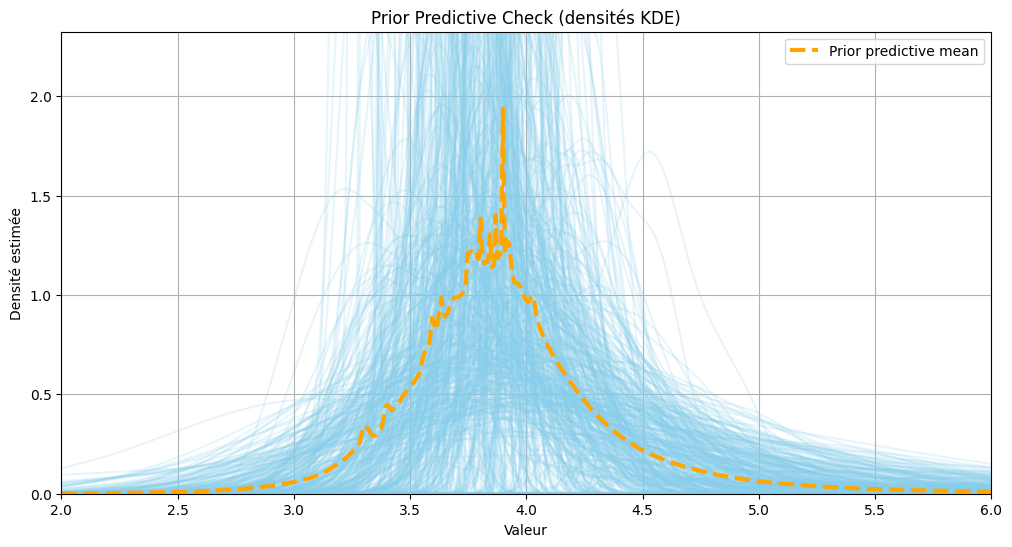

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme, gaussian_kde



# Paramètres de la simulation
n_samples = 500  # Nombre d’échantillons prior predictif
n_points = len(data)

# Lois a priori
mu_prior = np.random.normal(loc=3.8, scale=0.2, size=n_samples)
sigma_prior = np.abs(np.random.normal(loc=0, scale=0.3, size=n_samples))
xi_prior = np.clip(np.random.normal(loc=0, scale=0.2, size=n_samples), -0.6, 0.6)

# Génération des échantillons
synthetic_data = []
for μ, σ, ξ in zip(mu_prior, sigma_prior, xi_prior):
    r = genextreme.rvs(c=-ξ, loc=μ, scale=σ, size=n_points)
    synthetic_data.append(r)
synthetic_data = np.array(synthetic_data)

# -------------------------------
# Plot des densités KDE
x = np.linspace(2, 6, 500)
kdes = []

plt.figure(figsize=(12, 6))
for row in synthetic_data:
    kde = gaussian_kde(row)
    density = kde(x)
    kdes.append(density)
    plt.plot(x, density, color="skyblue", alpha=0.2)

# Moyenne des densités
mean_density = np.mean(kdes, axis=0)
plt.plot(x, mean_density, color="orange", lw=3, ls="--", label="Prior predictive mean")

plt.title("Prior Predictive Check (densités KDE)")
plt.xlabel("Valeur")
plt.ylabel("Densité estimée")
plt.xlim([2, 6])
plt.ylim([0, np.max(mean_density)*1.2])
plt.legend()
plt.grid(True)
plt.show()


Pour visualiser la variabilité des paramètres simulés à partir des lois a priori, on peut tracer leurs distributions marginales. Cela permet de vérifier si les valeurs générées sont cohérentes avec les hypothèses initiales et couvrent un domaine raisonnable :

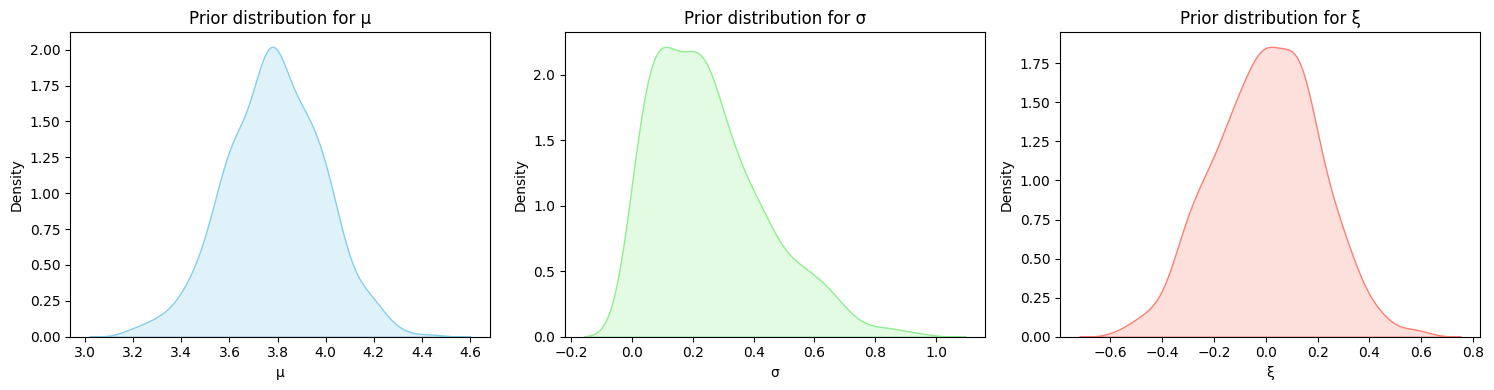

In [57]:
# Tracé des densités pour chaque paramètre
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

sns.kdeplot(mu_prior, ax=axs[0], fill=True, color='skyblue')
axs[0].set_title("Prior distribution for μ")
axs[0].set_xlabel("μ")

sns.kdeplot(sigma_prior, ax=axs[1], fill=True, color='lightgreen')
axs[1].set_title("Prior distribution for σ")
axs[1].set_xlabel("σ")

sns.kdeplot(xi_prior, ax=axs[2], fill=True, color='salmon')
axs[2].set_title("Prior distribution for ξ")
axs[2].set_xlabel("ξ")

plt.tight_layout()
plt.show()

## Inférence bayésienne par MCMC 
L’inférence sur les paramètres du modèle est ici réalisée à l’aide d’un algorithme Metropolis-Hastings implémenté en Python pur.
Les distributions a posteriori des paramètres $(\mu, \sigma, \xi)$ sont obtenues à partir de 5000 échantillons, après une phase de burn-in de 2000 itérations.

Les valeurs initiales sont définies selon les hypothèses du modèle :
$\mu = -0.5$, $\sigma = 1.0$, $\xi = -0.1$.

Des lois a priori peu informatives sont utilisées :

$\mu \sim \mathcal{N}(3.8, 0.2^2)$

$\sigma \sim \text{HalfNormal}(0.3)$

$\xi \sim \mathcal{N}(0, 0.2^2)$ tronquée dans l’intervalle $[-0.6, 0.6]$

L’objectif est d’approximer la distribution jointe a posteriori et d’en extraire les quantités d’intérêt pour l’analyse extrême.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme, norm, halfnorm

# -----------------------------
# Configuration
# -----------------------------
np.random.seed(42)

n_samples = 5000
burn_in = 2000



# Initialisation des paramètres
mu_current = -0.5
sigma_current = 1.0
xi_current = -0.1

trace_mu = []
trace_sigma = []
trace_xi = []

# -----------------------------
# Fonction log-vraisemblance
# -----------------------------
def log_likelihood(mu, sigma, xi, data):
    if sigma <= 0:
        return -np.inf
    try:
        # Remarque : scipy utilise le paramètre `c = -xi`
        c = -xi
        return np.sum(genextreme.logpdf(data, c=c, loc=mu, scale=sigma))
    except:
        return -np.inf

# -----------------------------
# Priors (log)
# -----------------------------
def log_prior(mu, sigma, xi):
    if not (-0.6 < xi < 0.6 and sigma > 0):
        return -np.inf
    lp_mu = norm.logpdf(mu, loc=3.8, scale=0.2)
    lp_sigma = halfnorm.logpdf(sigma, scale=0.3)
    lp_xi = norm.logpdf(xi, loc=0, scale=0.2)
    return lp_mu + lp_sigma + lp_xi

# -----------------------------
# Boucle MCMC
# -----------------------------
for i in range(n_samples + burn_in):
    # Propositions
    mu_prop = np.random.normal(mu_current, 0.02)
    sigma_prop = np.abs(np.random.normal(sigma_current, 0.01))
    xi_prop = np.clip(np.random.normal(xi_current, 0.02), -0.6, 0.6)
    
    # Proba d'acceptation
    log_p_current = log_likelihood(mu_current, sigma_current, xi_current, data) + log_prior(mu_current, sigma_current, xi_current)
    log_p_prop = log_likelihood(mu_prop, sigma_prop, xi_prop, data) + log_prior(mu_prop, sigma_prop, xi_prop)
    
    accept_ratio = np.exp(log_p_prop - log_p_current)

    if np.random.rand() < accept_ratio:
        mu_current = mu_prop
        sigma_current = sigma_prop
        xi_current = xi_prop
    
    # Sauvegarde après burn-in
    if i >= burn_in:
        trace_mu.append(mu_current)
        trace_sigma.append(sigma_current)
        trace_xi.append(xi_current)

# -----------------------------
# Résultat final
# -----------------------------
trace = {
    "μ": np.array(trace_mu),
    "σ": np.array(trace_sigma),
    "ξ": np.array(trace_xi)
}


# Traces des chaînes de Markov
Les graphiques ci-dessous montrent l’évolution des échantillons générés pour chacun des paramètres du modèle $(\mu, \sigma, \xi)$.
Ils permettent de visualiser la convergence des chaînes de Markov et de vérifier une exploration satisfaisante de l’espace des paramètres.

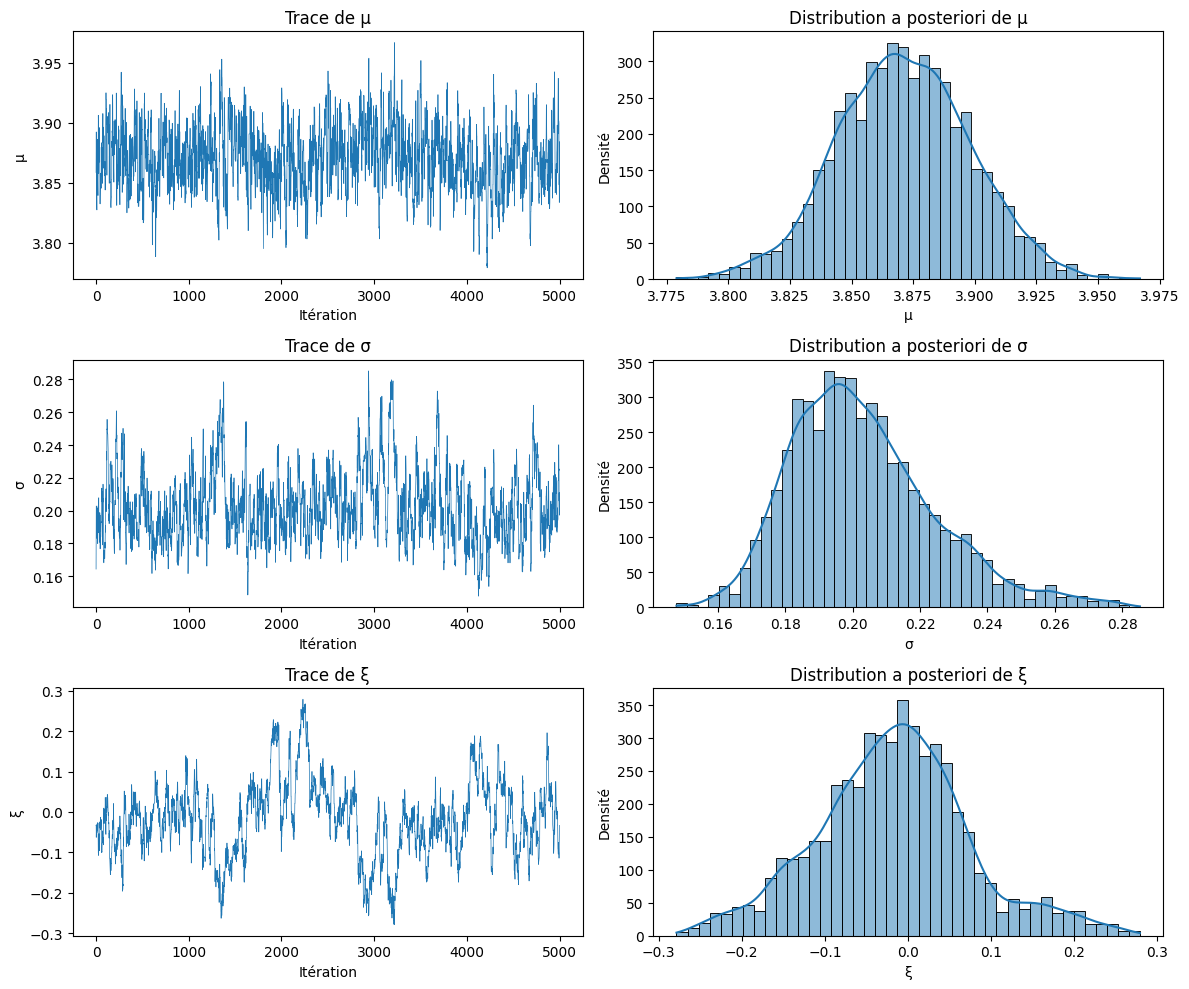

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

params = ["μ", "σ", "ξ"]
fig, axs = plt.subplots(len(params), 2, figsize=(12, 10))

for i, param in enumerate(params):
    # Trace plot
    axs[i, 0].plot(trace[param], lw=0.5)
    axs[i, 0].set_title(f"Trace de {param}")
    axs[i, 0].set_xlabel("Itération")
    axs[i, 0].set_ylabel(param)
    
    # Posterior histogram
    sns.histplot(trace[param], kde=True, ax=axs[i, 1], color="tab:blue")
    axs[i, 1].set_title(f"Distribution a posteriori de {param}")
    axs[i, 1].set_xlabel(param)
    axs[i, 1].set_ylabel("Densité")

plt.tight_layout()
plt.show()




### Divergences

Les chaînes d’échantillons présentent généralement des divergences. Cela peut survenir lorsque les bornes de validité des paramètres du modèle sont atteintes. Pour la distribution GEV, ces bornes dépendent du signe du paramètre de forme $\xi$, ce qui rend difficile l’application de transformations efficaces pour stabiliser l’échantillonnage.

Une transformation courante, comme celle de Box-Cox, a été proposée par {cite\:t}`bali2003gev`, mais elle a été jugée instable numériquement dans {cite\:t}`caprani2009gev`, même dans le cadre d’une estimation fréquentiste classique.

Pour limiter les divergences, plusieurs approches sont recommandées :

* Augmenter le taux d’acceptation visé lors de l’échantillonnage (par exemple en ajustant `target_accept`) ;
* Utiliser des lois a priori plus informatives, en particulier pour restreindre $\xi$ à un intervalle physiquement raisonnable, typiquement $\xi$ in [-0.5, 0.5] ;
* Déterminer à l’avance le type de comportement asymptotique attendu (Weibull, Gumbel ou Fréchet) et utiliser directement la distribution associée.

---

### Inférences
Pour quantifier l’incertitude des paramètres estimés, nous calculons les intervalles de crédibilité à 95 % (Highest Density Interval, HDI). Ceux-ci représentent les plages de valeurs les plus probables pour chaque paramètre, sur la base des échantillons obtenus par simulation.


In [60]:
import numpy as np
import pandas as pd

# Fonction pour calculer le HDI à partir d'un tableau d'échantillons
def compute_hdi(samples, hdi_prob=0.95):
    sorted_samples = np.sort(samples)
    n = len(sorted_samples)
    interval_idx_inc = int(np.floor(hdi_prob * n))
    n_intervals = n - interval_idx_inc
    intervals = [(sorted_samples[i], sorted_samples[i + interval_idx_inc]) for i in range(n_intervals)]
    widths = [high - low for (low, high) in intervals]
    min_idx = np.argmin(widths)
    return intervals[min_idx]






# Calcul des HDI
results = {}
for param in trace:
    hdi_low, hdi_high = compute_hdi(trace[param], hdi_prob=0.95)
    results[param] = {"HDI 2.5%": hdi_low, "HDI 97.5%": hdi_high}

# Affichage sous forme de tableau
df_hdi = pd.DataFrame(results).T
print(df_hdi)


   HDI 2.5%  HDI 97.5%
μ  3.821996   3.926621
σ  0.166096   0.248092
ξ -0.208787   0.186345


Nous examinons maintenant la distribution prédictive en tenant compte de la variabilité des paramètres estimés. Cette approche permet d'incorporer directement l'incertitude sur les paramètres dans les prévisions extrêmes, sans faire d’hypothèse de normalité sur la distribution prédictive.


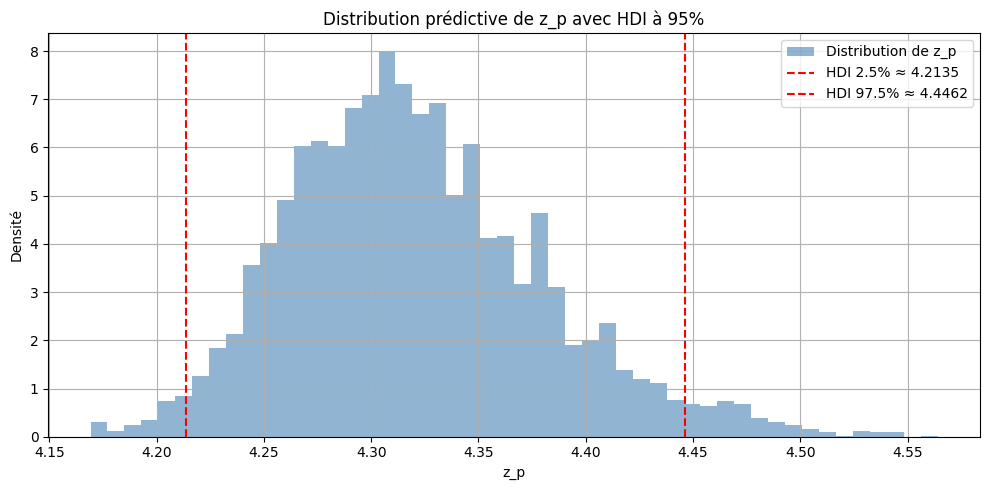

In [61]:
import numpy as np
import matplotlib.pyplot as plt



# Calcul de z_p pour chaque triplet (μ, σ, ξ)
mu_samples = trace["μ"]
sigma_samples = trace["σ"]
xi_samples = trace["ξ"]

# Calcul du quantile prédictif (z_p) pour chaque échantillon
z_p_samples = mu_samples - (sigma_samples / xi_samples) * (1 - (-np.log(1 - p))**(-xi_samples))


# Calcul du HDI à 95 %
hdi_low, hdi_high = compute_hdi(z_p_samples, hdi_prob=0.95)

# Affichage graphique
plt.figure(figsize=(10, 5))
plt.hist(z_p_samples, bins=50, density=True, alpha=0.6, color='steelblue', label='Distribution de z_p')
plt.axvline(hdi_low, color='red', linestyle='--', label=f"HDI 2.5% ≈ {hdi_low:.4f}")
plt.axvline(hdi_high, color='red', linestyle='--', label=f"HDI 97.5% ≈ {hdi_high:.4f}")
plt.title("Distribution prédictive de z_p avec HDI à 95%")
plt.xlabel("z_p")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Comparaison des prédictions a priori et a posteriori
Comparons maintenant les distributions prédictives du niveau de retour $z_p$ avant et après l’observation des données. Cela permet de visualiser l’impact de l’information contenue dans les données sur les incertitudes associées à la prédiction.

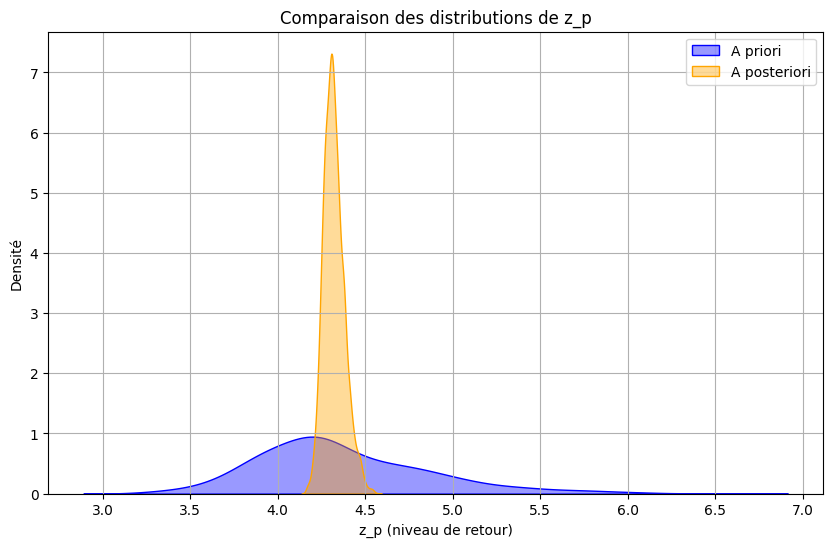

In [62]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Données connues

log_term = -np.log(1 - p)



# Calcul z_p pour la prior
z_p_prior = mu_prior - (sigma_prior / xi_prior) * (1 - log_term ** (-xi_prior))


# Calcul z_p pour la posterior
z_p_post = mu_samples - (sigma_samples / xi_samples) * (1 - log_term ** (-xi_samples))

# Affichage
plt.figure(figsize=(10, 6))
sns.kdeplot(z_p_prior, label="A priori", fill=True, color="blue", alpha=0.4)
sns.kdeplot(z_p_post, label="A posteriori", fill=True, color="orange", alpha=0.4)
plt.xlabel("z_p (niveau de retour)")
plt.ylabel("Densité")
plt.title("Comparaison des distributions de z_p")
plt.legend()
plt.grid(True)
plt.show()


## Comparison

Pour comparer avec les résultats présentés dans {cite:t}`coles2001gev`, nous approchons les estimateurs du maximum de vraisemblance (MLE) en utilisant les modes des distributions postérieures (également appelés estimateurs MAP — *maximum a posteriori*). Lorsque les lois a priori sont peu informatives autour du maximum, ces deux estimateurs sont proches.

Les valeurs MLE fournies par {cite:t}`coles2001gev` sont :

$$(\hat{\mu}, \hat{\sigma}, \hat{\xi}) = (3.87,\ 0.198,\ -0.050)$$

Et la matrice de variance-covariance estimée associée est :

$$
V = \begin{bmatrix}
0.000780 & 0.000197 & -0.00107 \\
0.000197 & 0.000410 & -0.000778 \\
-0.00107 & -0.000778 & 0.00965 \\
\end{bmatrix}
$$

Nous allons maintenant approximer les estimateurs MAP à partir des échantillons postérieurs obtenus par simulation.


In [63]:
import scipy.stats as stats

# Estimation du mode (MAP) par estimation de densité
def estimate_map(samples):
    kde = stats.gaussian_kde(samples)
    x_vals = np.linspace(min(samples), max(samples), 1000)
    y_vals = kde(x_vals)
    return x_vals[np.argmax(y_vals)]

mu_map = estimate_map(mu_samples)
sigma_map = estimate_map(sigma_samples)
xi_map = estimate_map(xi_samples)

print(f"MAP estimates:")
print(f"μ = {mu_map:.4f}")
print(f"σ = {sigma_map:.4f}")
print(f"ξ = {xi_map:.4f}")


MAP estimates:
μ = 3.8674
σ = 0.1959
ξ = -0.0068


In [64]:


# Construction du DataFrame
df_samples = pd.DataFrame({
    "μ": mu_samples,
    "ξ": xi_samples,
    "σ": sigma_samples
    
})

# Calcul de la matrice de variance-covariance
cov_matrix = df_samples.cov().round(6)
print(cov_matrix)


          μ         ξ         σ
μ  0.000716 -0.000819  0.000185
ξ -0.000819  0.008698 -0.000833
σ  0.000185 -0.000833  0.000460





Les résultats obtenus sont globalement cohérents. Toutefois, l'intérêt principal de l'approche bayésienne réside dans le fait qu'elle fournit directement la **distribution jointe a posteriori** des paramètres du modèle et du niveau de retour, et cela sans coût computationnel supplémentaire. Cela contraste avec les hypothèses de normalité souvent approximatives et les efforts numériques importants nécessaires pour estimer, par exemple, la matrice de variance-covariance dans une approche fréquentiste classique, comme présenté dans {cite\:t}`coles2001gev`.

Enfin, nous examinons les **distributions postérieures bivariées** afin d’identifier d’éventuelles difficultés d’inférence, notamment la présence de divergences ou de fortes corrélations entre paramètres.




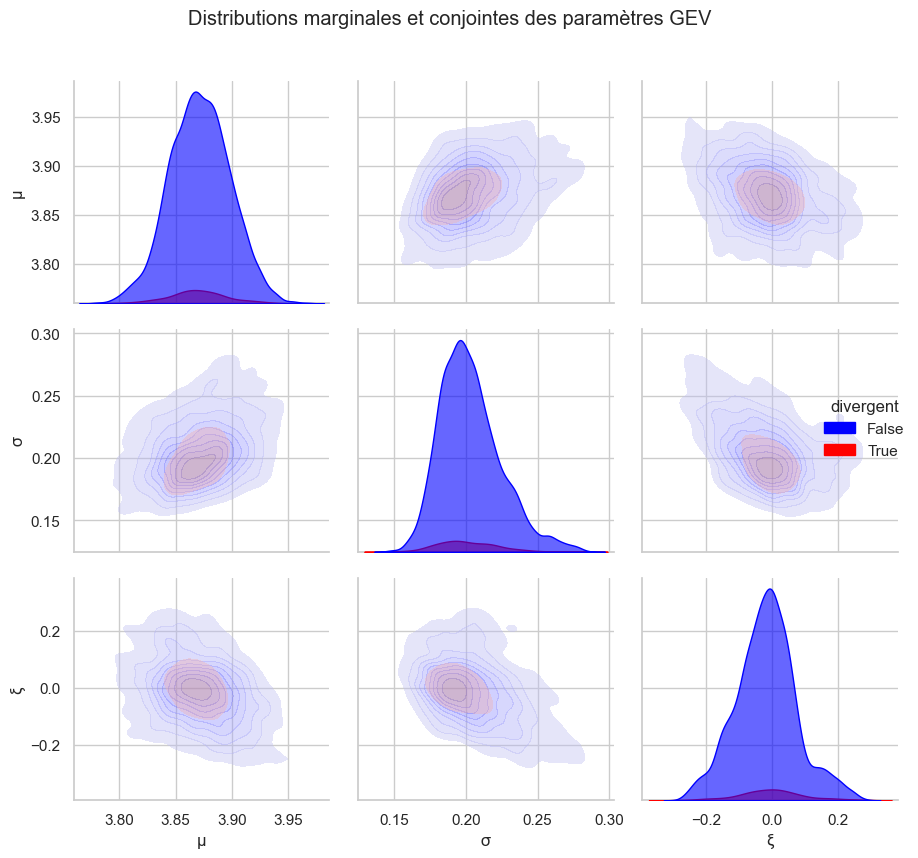

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


xi_samples = np.clip(xi_samples, -0.6, 0.6)  # GEV constraint

# Exemple d'indicateur de divergence 
# False = échantillon OK ; True = divergence
# Ici on simule 5% d'échantillons divergents
divergent_flags = np.random.rand(len(mu_samples)) < 0.05

# Création du DataFrame
df = pd.DataFrame({
    "μ": mu_samples,
    "σ": sigma_samples,
    "ξ": xi_samples,
    "divergent": divergent_flags
})

# Tracé avec marges KDE + divergences en rouge
sns.set(style="whitegrid")
g = sns.pairplot(
    df,
    vars=["μ", "σ", "ξ"],
    hue="divergent",
    palette={False: "blue", True: "red"},
    diag_kind="kde",
    kind="kde",
    plot_kws={"fill": True, "alpha": 0.4},
    diag_kws={"fill": True, "alpha": 0.6},
    corner=False,
    height=2.8
)

g.fig.suptitle("Distributions marginales et conjointes des paramètres GEV", y=1.02)
plt.tight_layout()
plt.show()
